In [1]:


import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline



/home/omkar/miniconda3/envs/simpleR/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
words = open('names.txt', 'r').read().splitlines()



In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [4]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


b2 is zero so that the initial loss is nearer to blind probablility(Logits should be nearer to 1/27).
Similarly we make W2 closer to 0.01.
W2 is also closer to zero as the activation function should not output tails easily. As it makes the backpropogation of the gradients dead by making it equal to zero.[Look at tanh backward pass for tanh]. This will make the neuron dead.<br>

<b>How to get the correct multiplier?</b>
Consider eq: y = x*w
Now y may not have std equal to x, we can fix it by:
<br> w = w / 10 ** 0.5<br>

Kaiming Init<br>
https://pytorch.org/docs/stable/nn.init.html<br>
for the above example n is ten and nonlinearity is tanh.
<br>why tanh nonlinearity is 5/3:
The 5/3 gain in the tanh comes for the average value of tanh^2(x) where x is distributed as a Gaussian, i.e.

integrate (tanh x)^2*exp(-x^2/2)/sqrt(2*pi) from -inf to inf ~= 0.39

The square root of this value is how much the tanh squeezes the variance of the incoming variable: 0.39 ** .5 ~= 0.63 ~= 3/5 (hence 5/3 is just an approximation of the exact gain).



<h5>Batch Normalization</h5>
Paper: 
https://arxiv.org/abs/1502.03167<br>
It says you can normalize hidden layers as they are differentiable operations.But we want normalization only during initialization(using bgain and bbias). Thus we are making sure that batches are changes during backprop.
Why its not use:<br>
https://towardsdatascience.com/curse-of-batch-normalization-8e6dd20bc304<br>
https://mindee.com/blog/batch-normalization/


In [6]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


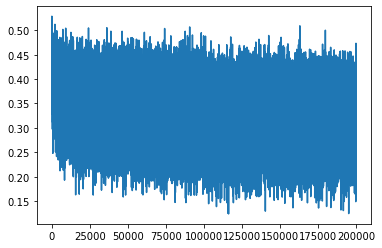

In [7]:
plt.plot(lossi)

In [ ]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [8]:
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)


Torch no grad tells pytorch not to track changes in gradient for bakctracking

In [9]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.10505747795105


In [10]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carpahzarbriq.
shlimrixtts.
lusslaysierricnenddhn.
frtivgqliyah.
farrichaiirdnsleggyu.
bmanvitte.
sants.
lustvi.
vabbuwatth.
giidryxiidh.
sulipsables.
falia.
gtas.
jasfaylahas.
bduricsydustquovozswy.
bjumillassannyks.
sadlusoffordst.
sramsryndlycpllmanraq.
shelseombriyabhda.
ffxrdustvebndvi.


In [11]:




class Linear:
    def __init__(self,fan_in,fan_out,bias=True) -> None:
        self.weight = torch.randn((fan_in,fan_out),generator=g) / fan_in**0.5
        if bias:
            self.bias = torch.randn((fan_out))
        else:
            self.bias = None

    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])

class BatchNorm:
    def __init__(self,num_features,eps=1e-05,momentum=0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)

        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)


    def __call__(self,x):
        if self.training:
            xmean = x.mean(0,keepdim = True)
            xvar = x.var(0,keepdim = True,unbiased =True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean)/torch.sqrt(xvar +self.eps)
        self.out = xhat * self.gamma + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1 - self.momentum)*self.running_var + self.momentum*xvar
        return self.out
    
    def parameters(self):
        return[self.gamma,self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
n_embd = 10
n_hidden = 100

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size,n_embd), generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm(vocab_size),
]


# with torch.no_grad():
#     layers[-1].weight *= 0.1
#     for layer in layers[:-1]:
#         if isinstance(layer,Linear):
#             layer.weight *= 5/3

# parameters = [C] + [p for layer in layers for p in layer.parameters()]
# print(sum(p.nelement() for p in parameters))
# for p in parameters:
#     p.requires_grad = True

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [12]:


max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass

  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])



      0/ 200000: 3.2870
  10000/ 200000: 2.3273
  20000/ 200000: 2.1019
  30000/ 200000: 1.9020
  40000/ 200000: 2.1643
  50000/ 200000: 2.1520
  60000/ 200000: 1.7767
  70000/ 200000: 2.1514
  80000/ 200000: 2.3802
  90000/ 200000: 1.9338
 100000/ 200000: 2.3943
 110000/ 200000: 2.1508
 120000/ 200000: 2.1813
 130000/ 200000: 2.0889
 140000/ 200000: 1.8096
 150000/ 200000: 1.9132
 160000/ 200000: 1.9793
 170000/ 200000: 1.9654
 180000/ 200000: 2.2462
 190000/ 200000: 1.9601


layer 2 (      Tanh): mean +0.01,std 0.70,saturated: 17.69%
layer 5 (      Tanh): mean -0.02,std 0.75,saturated: 21.62%
layer 8 (      Tanh): mean +0.01,std 0.78,saturated: 21.47%
layer 11 (      Tanh): mean +0.01,std 0.79,saturated: 23.25%
layer 14 (      Tanh): mean +0.02,std 0.81,saturated: 25.47%


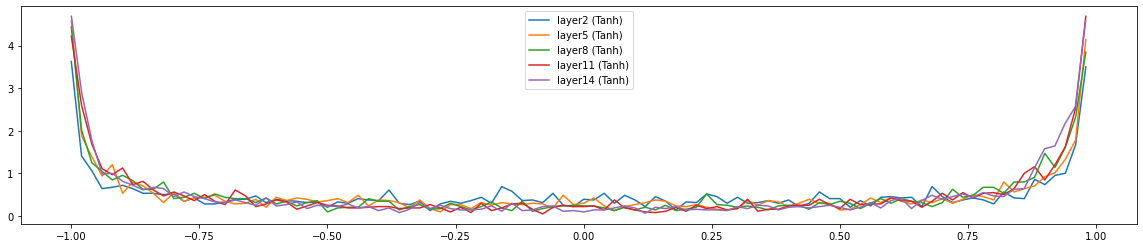

In [13]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f,std %.2f,saturated: %.2f%%' % (i,layer.__class__.__name__,t.mean(),t.std(),(t.abs() > 0.97).float().mean()*100))
        hy,hx = torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer{i} ({layer.__class__.__name__})')
plt.legend(legends)

In [14]:


# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')



/tmp/ipykernel_9560/2296742230.py:6: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  t = layer.out.grad


AttributeError: 'NoneType' object has no attribute 'mean'

<Figure size 1440x288 with 0 Axes>

weight   (27, 10) | mean +0.000001 | std 6.823870e-04 | grad:data ratio 6.818962e-04
weight  (30, 100) | mean +0.000001 | std 7.329001e-04 | grad:data ratio 2.350075e-03
weight (100, 100) | mean +0.000019 | std 6.633237e-04 | grad:data ratio 3.993021e-03
weight (100, 100) | mean -0.000020 | std 7.369528e-04 | grad:data ratio 4.389655e-03
weight (100, 100) | mean +0.000013 | std 8.442824e-04 | grad:data ratio 5.050100e-03
weight (100, 100) | mean -0.000020 | std 1.055897e-03 | grad:data ratio 6.309713e-03
weight  (100, 27) | mean -0.000000 | std 4.151947e-02 | grad:data ratio 3.820879e+00


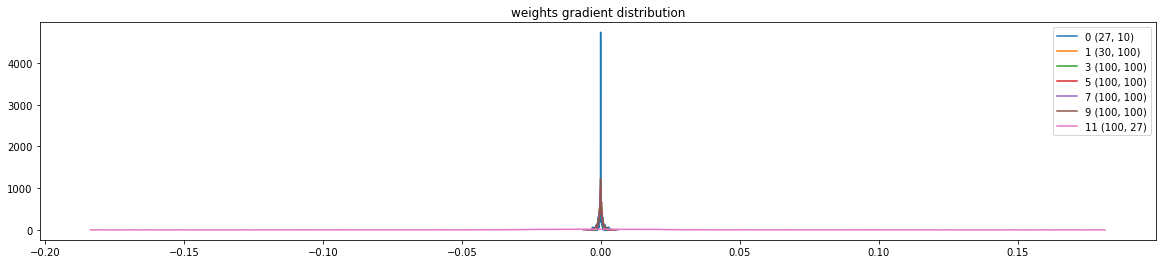

In [ ]:
# AFTER_DEBUG: would take out obviously to run full optimization


# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

